In [1]:
import json
import os
with open('./pleiades-places.json','r', encoding="utf8") as json_file, open('./pleiades_jsonline', 'a') as f1:
    f = json.load(json_file)
    for json_place in f["@graph"]:
        f1.write(json.dumps(json_place) + "\n")

In [1]:
import networkx as nx
import pandas as pd
df = pd.read_json(r'./pleiades_jsonline',lines=True)

In [2]:
df.head()
df.query('id==1001914')["connectsWith"].values
df.query('id==1001914')["connections"].values

array([list([{'end': None, 'description': '', 'contributors': [{'username': 'jbecker', 'homepage': None, 'name': 'Jeffrey Becker', 'uri': 'https://pleiades.stoa.org/author/jbecker'}], 'created': '2016-07-13T14:03:31Z', 'associationCertainty': 'certain', 'title': 'Lycia et Pamphylia', 'start': None, 'provenance': 'Pleiades', 'uri': 'https://pleiades.stoa.org/places/1001914/991384', 'connectionType': 'succeeds', 'id': '991384', 'attestations': [], 'history': [{'comment': 'Initial revision', 'modifiedBy': 'jbecker', 'modified': '2019-06-16T01:41:26Z'}], 'connectsTo': 'https://pleiades.stoa.org/errata/991384', 'details': '', 'references': [], 'review_state': 'published', 'creators': [{'username': 'sgillies', 'homepage': None, 'name': 'Sean Gillies', 'uri': 'https://pleiades.stoa.org/author/sgillies'}], '@type': 'Connection', 'connectionTypeURI': 'https://pleiades.stoa.org/vocabularies/relationship-types/succeeds'}, {'end': None, 'description': '', 'contributors': [], 'created': '2016-07-13

In [3]:
#>>> d = {0: {1: {'weight':1}}} # dict-of-dicts single edge (0,1)
df_filtered = df.drop(columns=['provenance', 'review_state', 'rights', 'reprPoint','type', 'created', 'creators', 'references', 'contributors', 'history'])
df_filtered.columns
df.head()
df.shape

(37151, 25)

In [4]:
df_filtered.query('uri == "https://pleiades.stoa.org/places/59826"')
df['@type'].unique()
df_num_without_conn = df[df['connectsWith'].map(lambda d: len(d)) > 0]
df_num_without_conn.head()["connections"].values.tolist()

[[{'end': None,
   'description': '',
   'contributors': [],
   'created': '2016-11-04T16:36:13Z',
   'associationCertainty': 'certain',
   'title': 'Alba Fucens',
   'start': None,
   'provenance': 'Pleiades',
   'uri': 'https://pleiades.stoa.org/places/48210385/3733956186',
   'connectionType': ['at'],
   'id': '3733956186',
   'attestations': [],
   'history': [],
   'connectsTo': 'https://pleiades.stoa.org/places/413005',
   'details': '',
   'references': [],
   'review_state': 'published',
   'creators': [{'username': 'thomase',
     'homepage': None,
     'name': 'Tom Elliott',
     'uri': 'https://pleiades.stoa.org/author/thomase'}],
   '@type': 'Connection',
   'connectionTypeURI': "https://pleiades.stoa.org/vocabularies/relationship-types/['at']"}],
 [{'end': None,
   'description': '',
   'contributors': [],
   'created': '2016-11-04T16:39:10Z',
   'associationCertainty': 'certain',
   'title': 'Vulci',
   'start': None,
   'provenance': 'Pleiades',
   'uri': 'https://pleiad

In [5]:
len(df_num_without_conn.index)

7237

In [6]:
def parse_id(s):
    return s[s.rfind("/")+1:]

In [7]:
G = nx.Graph()
for index, row in df_filtered.iterrows():
    G.add_node(str(row['id']), title=row['title'], uuid=row['id'],object_type=row['@type'], placeTypes=row['placeTypes'], names=row['names'], description=row.get('description'))
    for c in row['connectsWith']:
        if "places" in c:
            G.add_edge(str(row['id']), parse_id(c))
            for connection_detail in row['connections']:
                if connection_detail['connectsTo'] == c:
                    G.add_edge(str(row['id']), parse_id(c), connectionType=connection_detail["connectionType"], uri=connection_detail["uri"])

#         G.add_node(parse_id(str(c['connectsTo']), title=c['title'], uuid=c['id'], object_type=c.get('@type'), placeTypes=c.get('placeTypes'), names=c.get('names'), description=c.get('description'))

len(G.nodes.data())

37909

In [41]:
[n for n in G.neighbors('265886')]
[n for n in G.edges('462492')]
G.edges['462492','50391614']

{'uuid': '1',
 'connectionType': 'connection',
 'uri': 'https://pleiades.stoa.org/places/50391614/462492'}

In [37]:
print(len(G.nodes.keys()))
print(len(df['id'].tolist()))
dupes = {}
keys = set([str(k) for k in G.nodes.keys()])
ids = set([str(i) for i in df['id'].tolist()])
diff= (keys - ids)
print(list(diff)[:5])
len([x for x in nx.isolates(G)])

37909
37151
['483124987', '508645486', '837378916', '463398873', '260256453']


29793

In [8]:
[x for x in nx.isolates(G)][:5]

['265878', '265882', '265886', '265890', '265891']

In [31]:
pr = nx.pagerank(G)
pr_results = dict(sorted(pr.items(), key=lambda x: x[1], reverse=True)[:10])
print(pr_results)

{'462492': 0.01111514744235289, '472014': 0.008632852443424266, '91358': 0.008058660269722621, '423025': 0.00692470434074566, '707498': 0.004554251110639502, '589748': 0.004052597981441311, '433032': 0.003436493291550076, '356966898': 0.0026583633810348295, '560221': 0.0020404074841917576, '1004': 0.0017709757370469247}


In [25]:


for i in pr_results:
    print(G.nodes[i])
    print()
#compute page rank for most important nodes. Identify the most influential vertices in a graph based on connections - as a measure of centrality
#find which node id's are not in the original set
#finding community centers
#change to directed graph?
#https://docs.databricks.com/spark/latest/graph-analysis/graphframes/user-guide-python.html
#http://snap.stanford.edu/class/cs224w-2017/projects/cs224w-9-final.pdf
#https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/strongly-connected-components/

{'title': 'Borgo Medievale', 'uuid': 48210385, 'object_type': 'Place', 'placeTypes': ['settlement'], 'names': [], 'description': 'The post-Roman settlement at Alba Fucens became an administrative center ca. A.D. 870 and remained significant as a center in Marsica until ca. 1143. The area was later subsumed by the Duchy of Spoleto.'}

{'title': 'Tempio Grande at Vulci', 'uuid': 48210386, 'object_type': 'Place', 'placeTypes': ['temple-2'], 'names': [], 'description': 'A major urban sanctuary at Vulci with a long period of use, stretching from the archaic period into the Roman period.'}

{'title': 'Consabura/Consabrum', 'uuid': 265876, 'object_type': 'Place', 'placeTypes': ['settlement'], 'names': [{'nameType': 'geographic', 'transcriptionAccuracy': 'accurate', 'associationCertainty': 'certain', 'romanized': 'Consabura', 'attestations': [{'timePeriod': 'hellenistic-republican', 'timePeriodURI': 'https://pleiades.stoa.org/vocabularies/time-periods/hellenistic-republican', 'confidence': 'co

{'title': 'Mactaris',
 'uuid': 324774,
 'object_type': 'Place',
 'placeTypes': ['settlement'],
 'names': [{'nameType': 'geographic',
   'transcriptionAccuracy': 'accurate',
   'associationCertainty': 'certain',
   'romanized': 'Mactaris',
   'attestations': [{'timePeriod': 'hellenistic-republican',
     'timePeriodURI': 'https://pleiades.stoa.org/vocabularies/time-periods/hellenistic-republican',
     'confidence': 'confident',
     'confidenceURI': 'https://pleiades.stoa.org/vocabularies/attestation-confidence/confident'},
    {'timePeriod': 'roman',
     'timePeriodURI': 'https://pleiades.stoa.org/vocabularies/time-periods/roman',
     'confidence': 'confident',
     'confidenceURI': 'https://pleiades.stoa.org/vocabularies/attestation-confidence/confident'},
    {'timePeriod': 'late-antique',
     'timePeriodURI': 'https://pleiades.stoa.org/vocabularies/time-periods/late-antique',
     'confidence': 'confident',
     'confidenceURI': 'https://pleiades.stoa.org/vocabularies/attestatio

In [16]:
from networkx.readwrite import json_graph
import json
data1 = json_graph.node_link_data(G, {'link': 'edges', 'source': 'from', 'target': 'to'})
with open('data.json', 'w') as f:
    json.dump(data1, f)

In [ ]:
len(G.nodes.data())

In [62]:
df.shape

(37151, 25)

In [38]:
s[s.rfind("/")+1:]

'912977'

In [76]:
G_temp = nx.Graph()

In [13]:
G_temp.add_node(1, payload={"description": 'text here'})
G_temp.add_edge(1, 2)
G_temp.add_node(1, payload={"description": 'another one'})
G_temp.add_node(2, payload={"description": 'another two'})
G_temp.add_edge(2, 1, description="edge 1")
G_temp.add_edge(3, 1)
G_temp.add_edge(1, 2, description="edge 2")


NameError: name 'G_temp' is not defined

In [78]:
print(G_temp.nodes.data())
print(G_temp.edges.data())
len(G_temp.nodes[3])
print()
for n in G_temp:
    print(G_temp.nodes[n])

[(1, {'payload': {'description': 'another one'}}), (2, {'payload': {'description': 'another two'}}), (3, {})]
[(1, 2, {'description': 'edge 2'}), (1, 3, {})]

{'payload': {'description': 'another one'}}
{'payload': {'description': 'another two'}}
{}


C:\Users\Jeremy\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


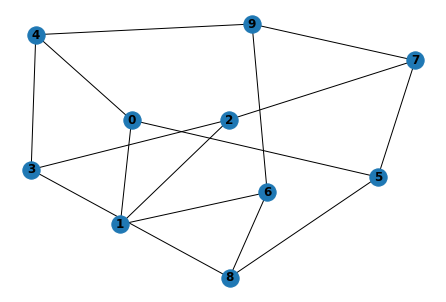

In [7]:
import matplotlib.pyplot as plt
G = nx.petersen_graph()
nx.draw(G, with_labels=True, font_weight='bold')